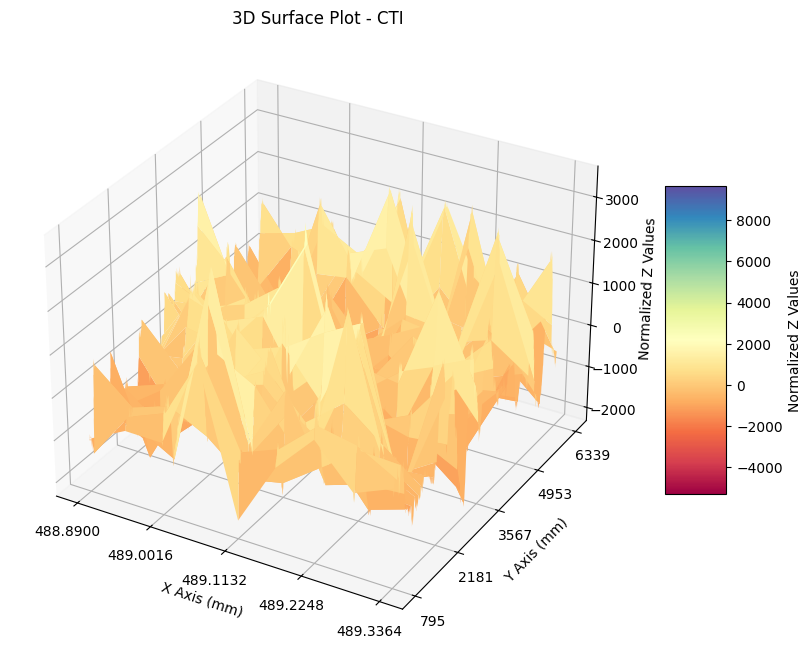

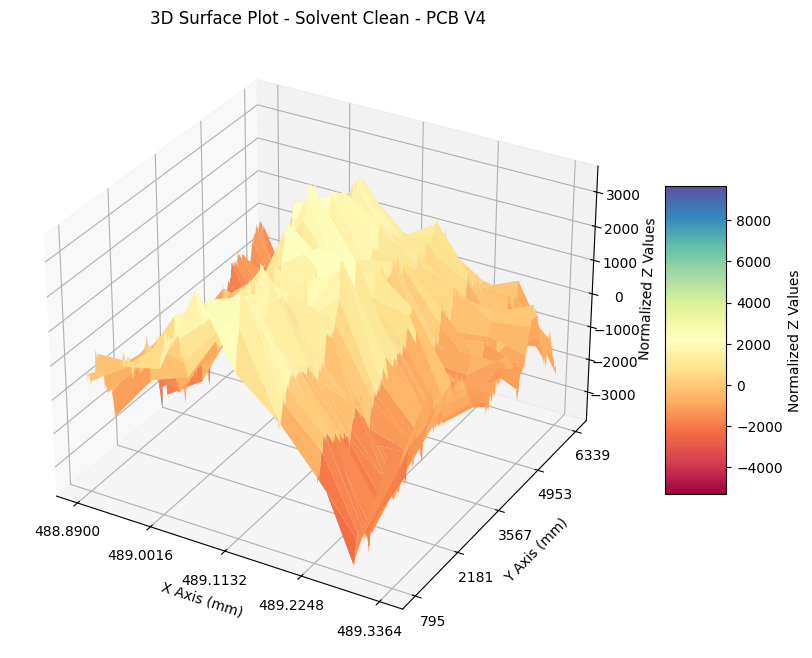

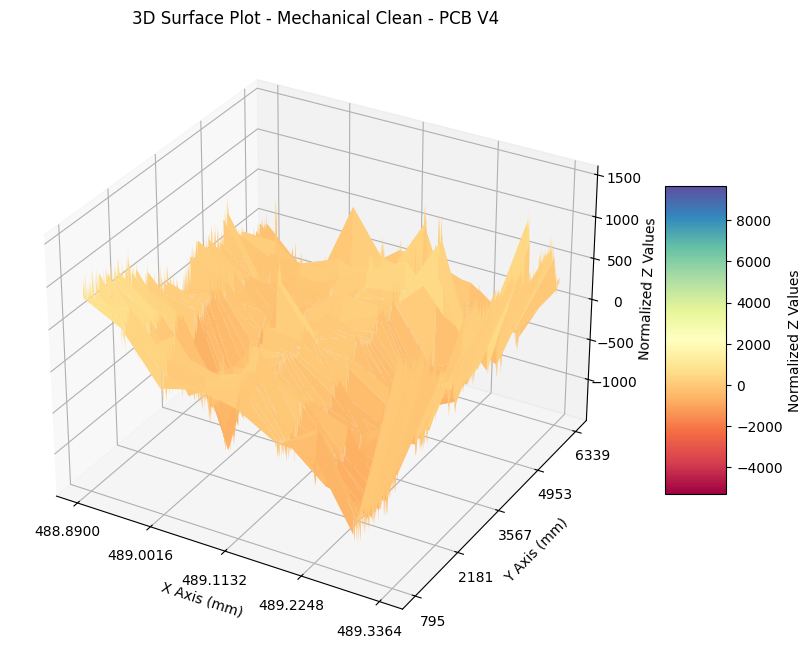

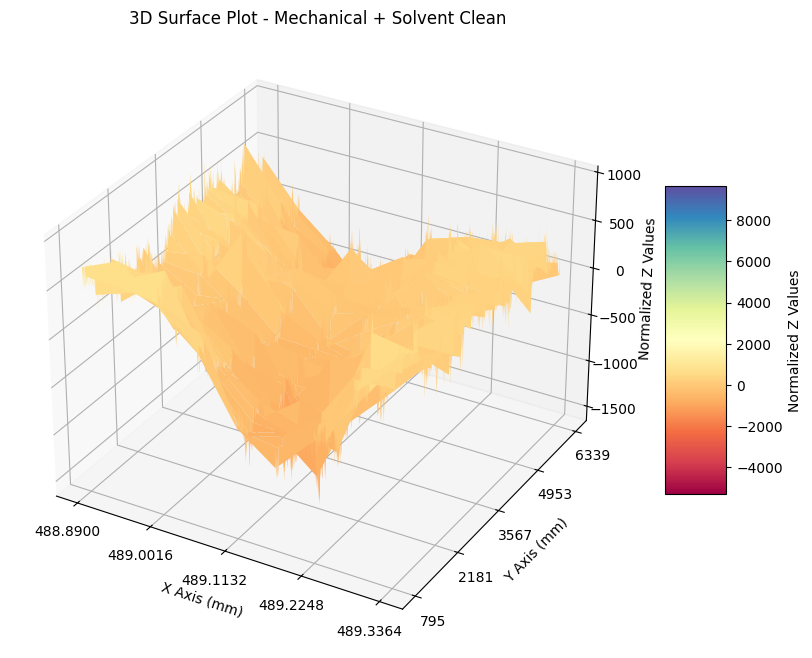

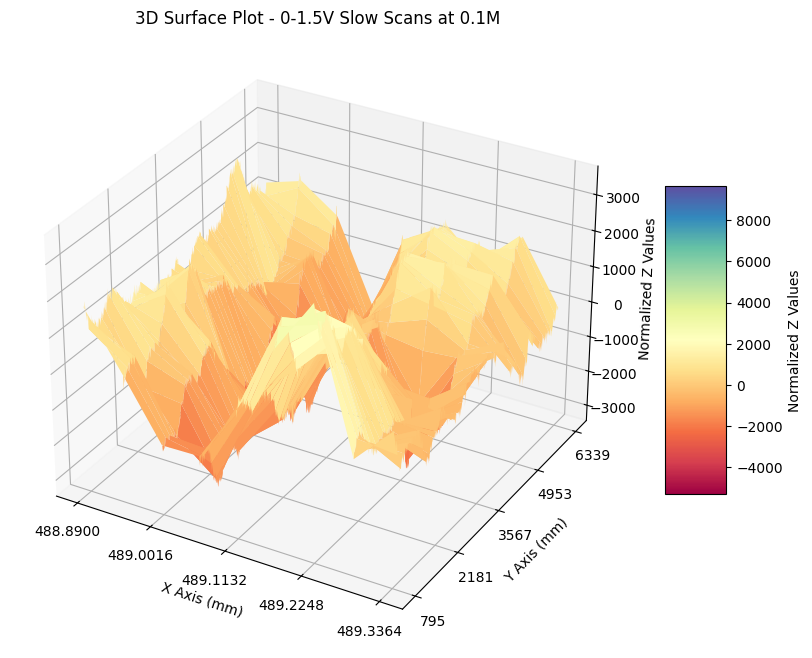

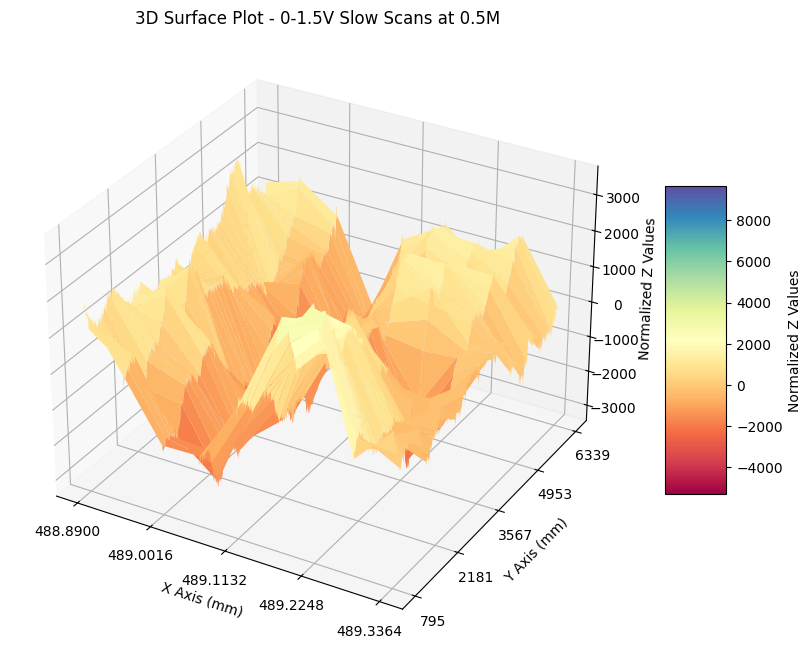

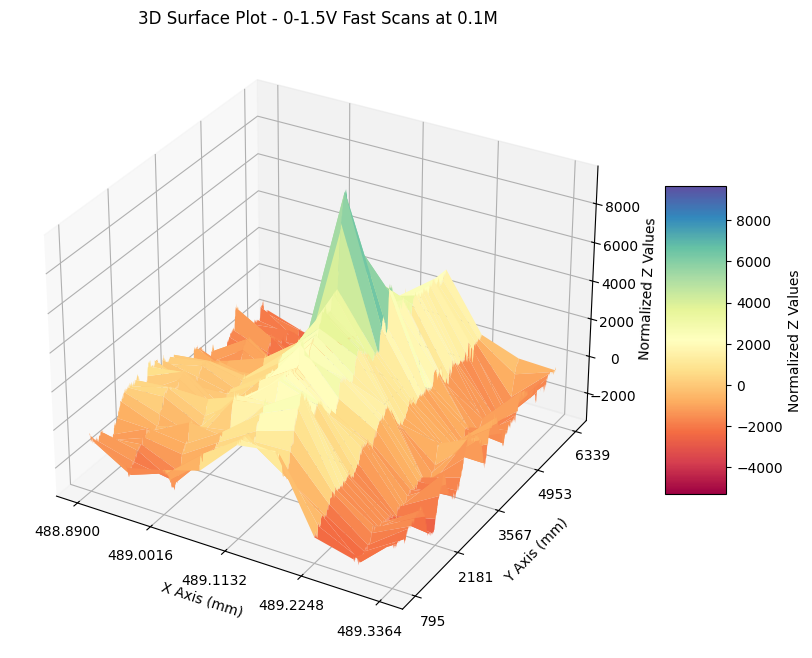

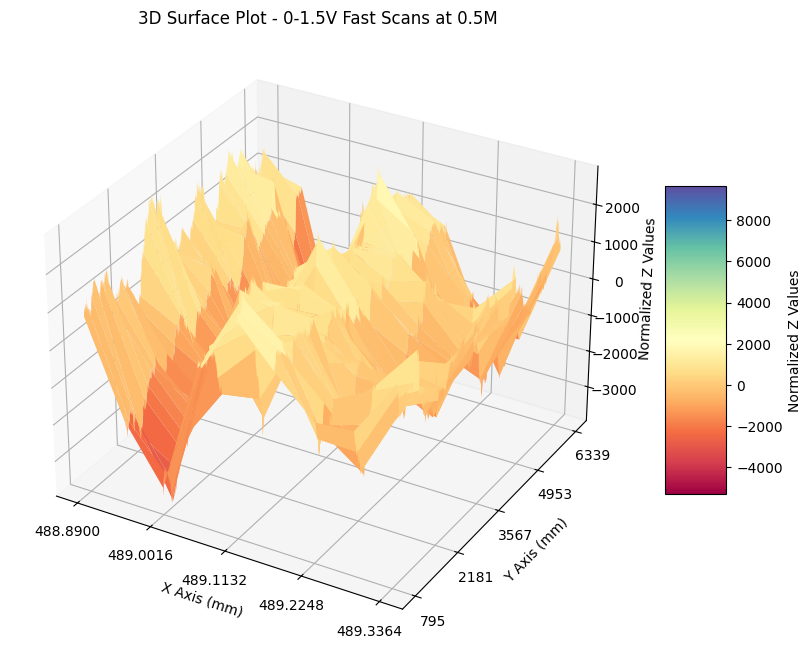

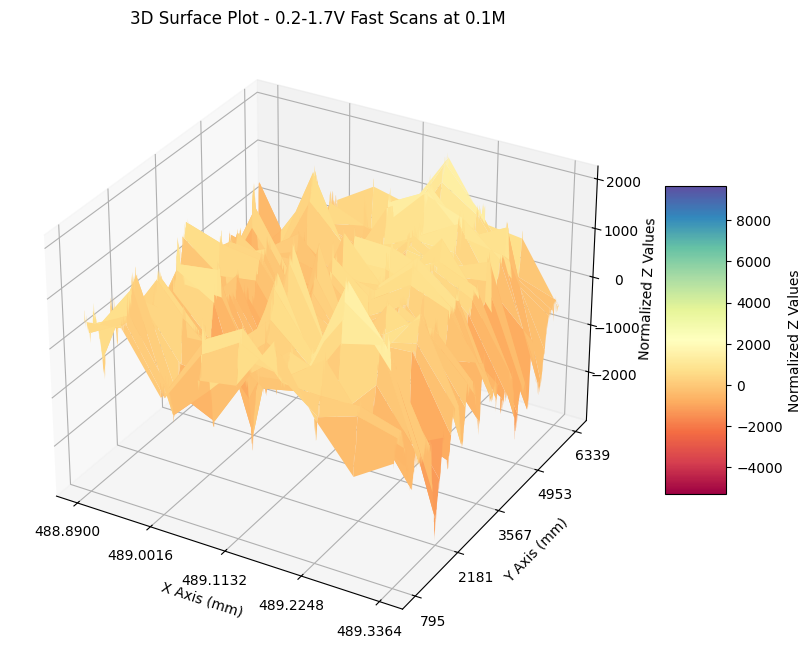

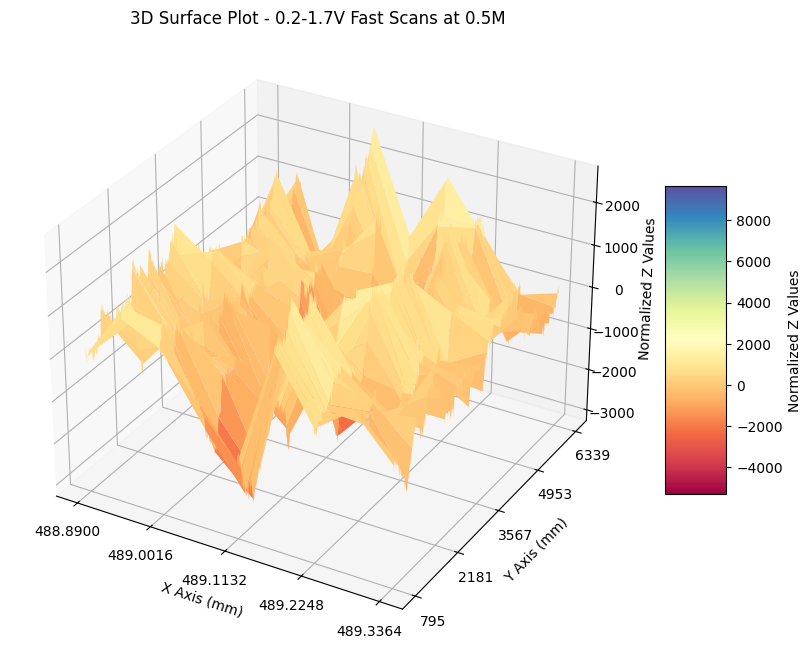

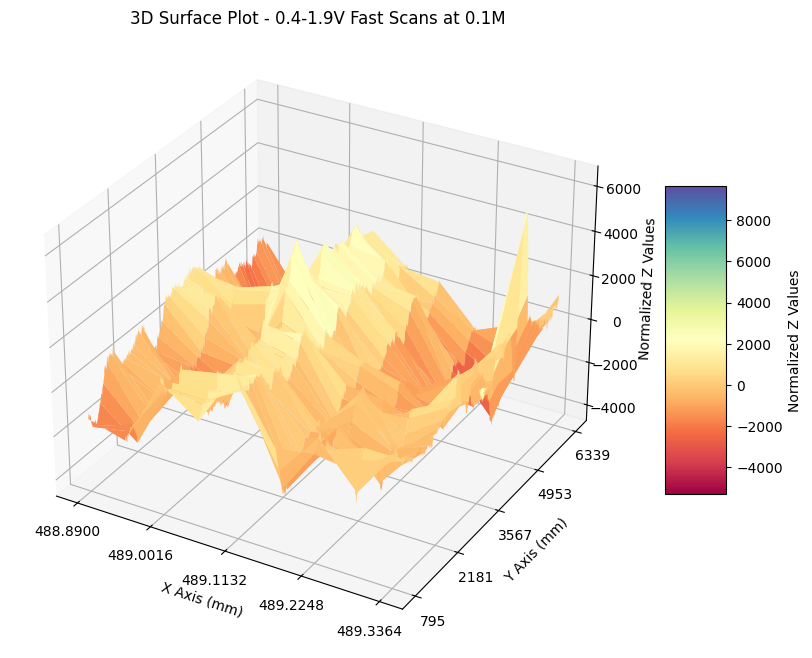

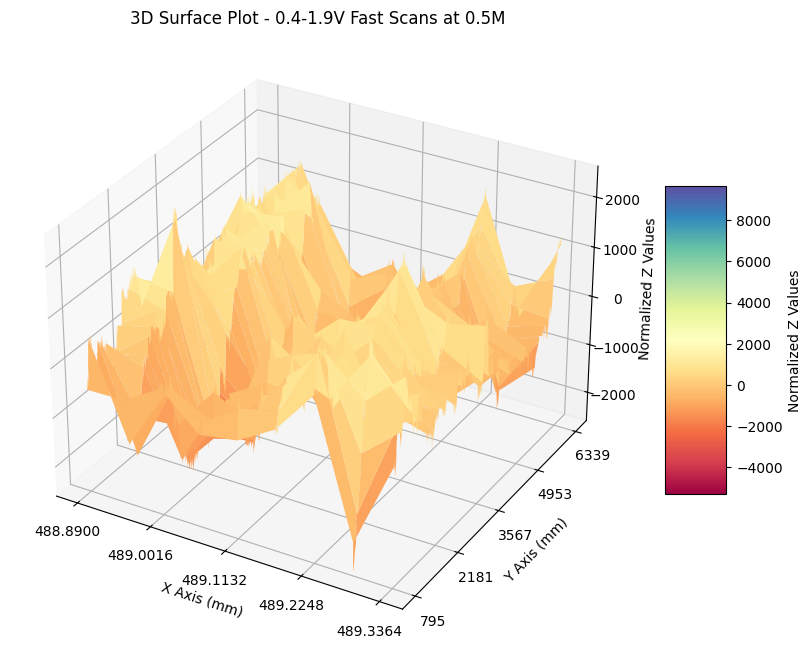

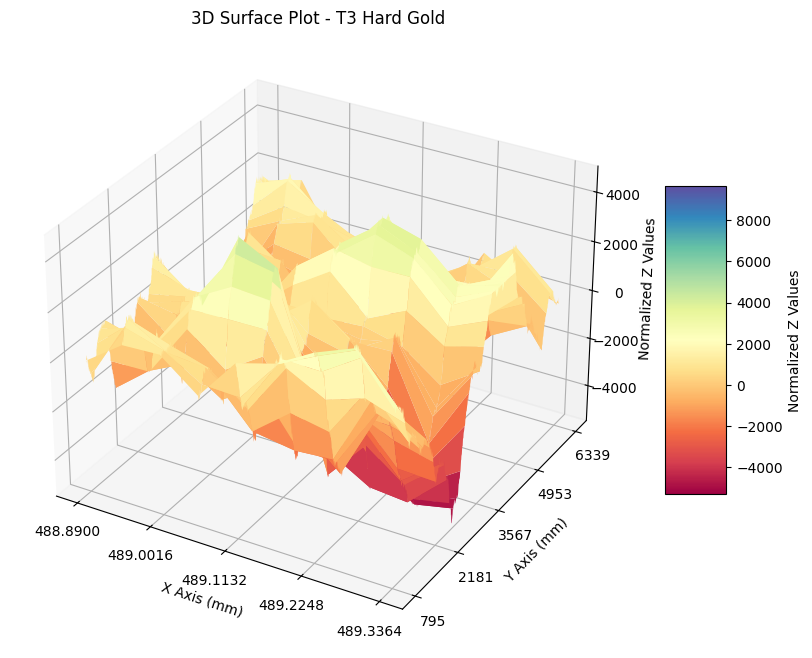

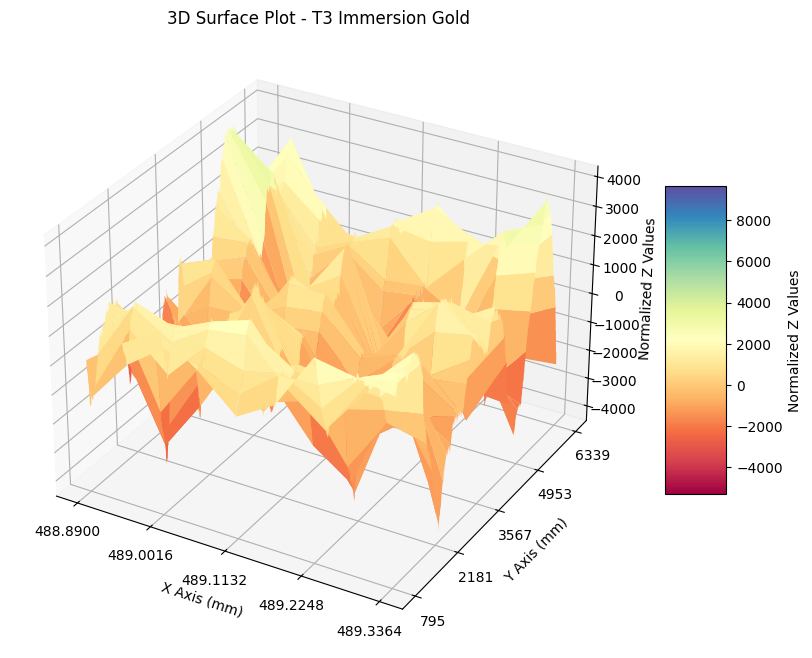

Sheet Name,Ra (Arithmetic Average Roughness),RSm (Slope of the material ratio curve),Wz (Average Waviness Height),Skewness,Kurtosis
CTI,747.942977,0.437014,5609.673182,0.718406,0.535474
Solvent Clean - PCB V4,1175.740223,-0.349525,7202.632922,0.008602,-0.656488
Mechanical Clean - PCB V4,376.147386,-0.246423,2880.098385,0.054793,-0.082294
Mechanical + Solvent Clean,326.835746,-0.439750,2485.607941,-0.412307,-0.191162
0-1.5V Slow Scans at 0.1M,985.389560,0.088048,6834.140992,-0.197563,-0.367633
0-1.5V Slow Scans at 0.5M,985.389560,0.088048,6834.140992,-0.197563,-0.367633
0-1.5V Fast Scans at 0.1M,1472.069613,0.403604,12787.905299,1.143750,2.447781
0-1.5V Fast Scans at 0.5M,1010.743196,-0.214577,6564.209250,-0.546961,-0.276961
0.2-1.7V Fast Scans at 0.1M,658.445198,0.226008,4894.088893,-0.280231,-0.219321
0.2-1.7V Fast Scans at 0.5M,738.857711,0.307763,5744.028609,-0.344748,0.204537


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

# Load Excel file and get sheet names
file_path = r'C:\Users\kulma\OneDrive\Documents\School\MASc Year 1\Surface Profilometry Analyzer\Surface-Profilometry-Analyzer\2Full_Surface_Profilometry_Organized_Samples_for_Program.xlsx'
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

# Coordinates and resolutions
x_coord = 488.89
y_coord = 795.28
x_resolution = 0.049603
y_resolution = 5.5

def calculate_surface_roughness(Z):
    Ra = np.mean(np.abs(Z - np.mean(Z)))
    gradient, _ = np.gradient(Z)
    RSm = np.mean(gradient)
    return Ra, RSm

def calculate_waviness_parameters(Z):
    valleys = np.partition(Z.flatten(), 5)[:5]
    peaks = np.partition(Z.flatten(), -5)[-5:]
    Wz = np.mean(np.abs(peaks - valleys))
    return Wz

def calculate_spatial_parameters(Z):
    skewness = stats.skew(Z.flatten())
    kurtosis = stats.kurtosis(Z.flatten())
    return skewness, kurtosis

def normalize_surface(Z, X, Y):
    # Flatten the X, Y, Z arrays
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = Z.flatten()
    
    # Fit a plane to the data
    A = np.c_[x_flat, y_flat, np.ones_like(x_flat)]
    C, _, _, _ = np.linalg.lstsq(A, z_flat, rcond=None)  # coefficients
    
    # Create the fitted plane
    Z_fit = C[0] * X + C[1] * Y + C[2]
    
    # Subtract the fitted plane from the original data to normalize
    Z_normalized = Z - Z_fit
    return Z_normalized

# Determine the global min and max for all sheets
global_z_min = float('inf')
global_z_max = float('-inf')

for sheet_name in sheet_names:
    # Load data from the current sheet
    df = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
    Z = df.values

    # Create meshgrid for X and Y based on the shape of Z
    x_points = Z.shape[1]
    y_points = Z.shape[0]
    x_values = np.linspace(x_coord, x_coord + x_points * x_resolution, x_points)
    y_values = np.linspace(y_coord, y_coord + y_points * y_resolution, y_points)
    X, Y = np.meshgrid(x_values, y_values)
    
    # Normalize the Z values
    Z_normalized = normalize_surface(Z, X, Y)
    
    global_z_min = min(global_z_min, Z_normalized.min())
    global_z_max = max(global_z_max, Z_normalized.max())

# Prepare a DataFrame to store results
results = []

for sheet_name in sheet_names:
    # Load data from the current sheet
    df = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
    Z = df.values

    # Create meshgrid for X and Y based on the shape of Z
    x_points = Z.shape[1]
    y_points = Z.shape[0]
    x_values = np.linspace(x_coord, x_coord + x_points * x_resolution, x_points)
    y_values = np.linspace(y_coord, y_coord + y_points * y_resolution, y_points)
    X, Y = np.meshgrid(x_values, y_values)
    
    # Normalize the Z values
    Z_normalized = normalize_surface(Z, X, Y)
    
    # Calculate surface roughness parameters
    Ra, RSm = calculate_surface_roughness(Z_normalized)
    
    # Calculate waviness parameters
    Wz = calculate_waviness_parameters(Z_normalized)
    
    # Calculate spatial parameters
    skewness, kurtosis = calculate_spatial_parameters(Z_normalized)
    
    # Store the results
    results.append([sheet_name, Ra, RSm, Wz, skewness, kurtosis])
    
    # Plotting the 3D surface plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the surface plot with a gold colormap
    surf = ax.plot_surface(X, Y, Z_normalized, cmap='Spectral', vmin=global_z_min, vmax=global_z_max)
    
    # Add a color bar which maps values to colors
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Normalized Z Values')
    
    # Label the axes with resolutions
    ax.set_xlabel('X Axis (mm)')
    ax.set_ylabel('Y Axis (mm)')
    ax.set_zlabel('Normalized Z Values')
    
    # Set ticks and labels based on resolution
    ax.set_xticks(np.linspace(x_coord, x_coord + x_points * x_resolution, 5))  # Adjust number of ticks as needed
    ax.set_yticks(np.linspace(y_coord, y_coord + y_points * y_resolution, 5))  # Adjust number of ticks as needed
    
    # Set the title to include the sheet name
    ax.set_title(f"3D Surface Plot - {sheet_name}")
    
    # Show the plot
    plt.show()

# Create a DataFrame to display the results in a tabular format
results_df = pd.DataFrame(results, columns=['Sheet Name', 'Ra (Arithmetic Average Roughness)', 'RSm (Slope of the material ratio curve)', 'Wz (Average Waviness Height)', 'Skewness', 'Kurtosis'])

# Display the results DataFrame
display(HTML(results_df.to_html(index=False)))


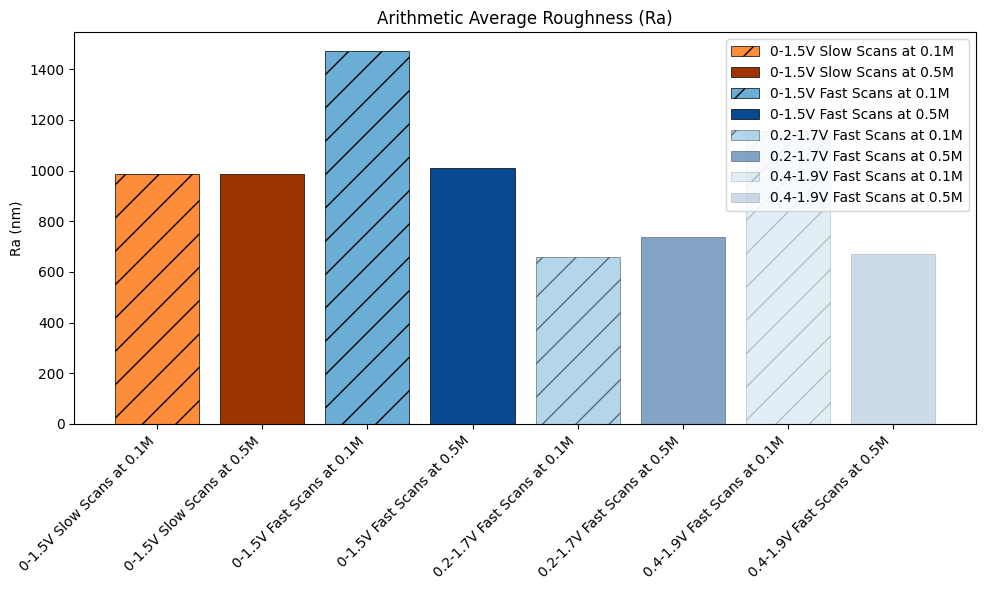

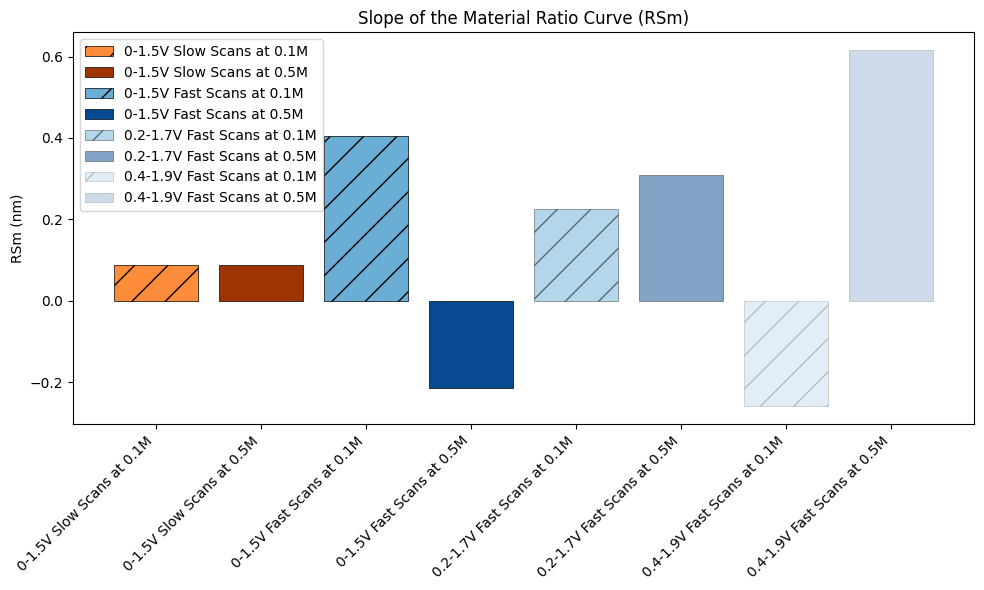

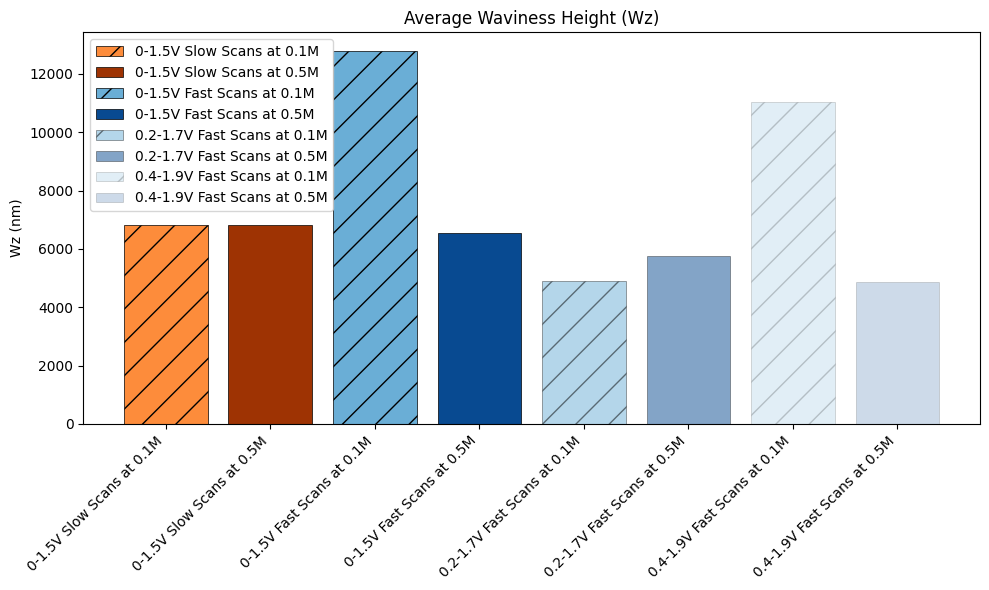

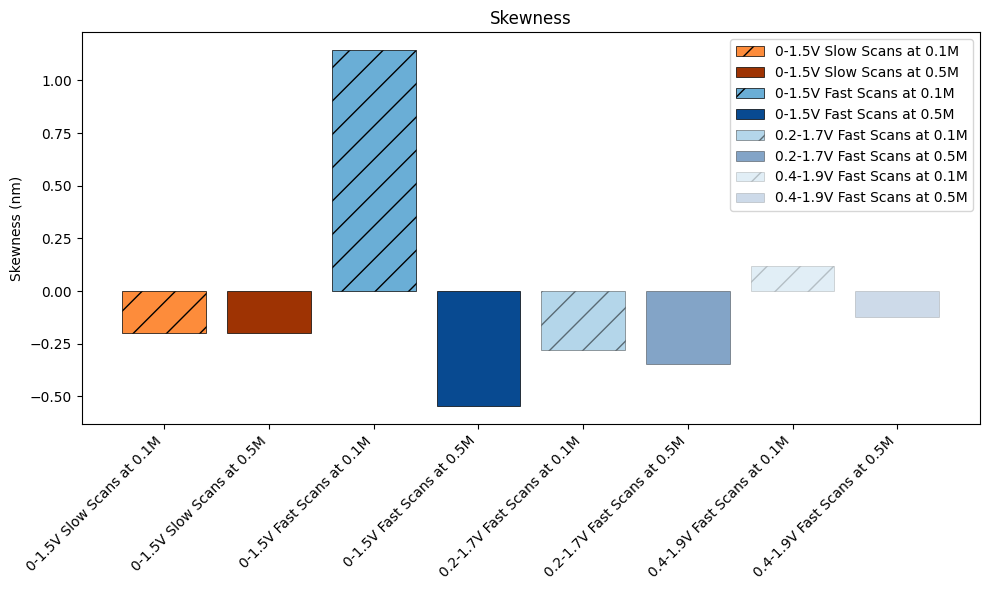

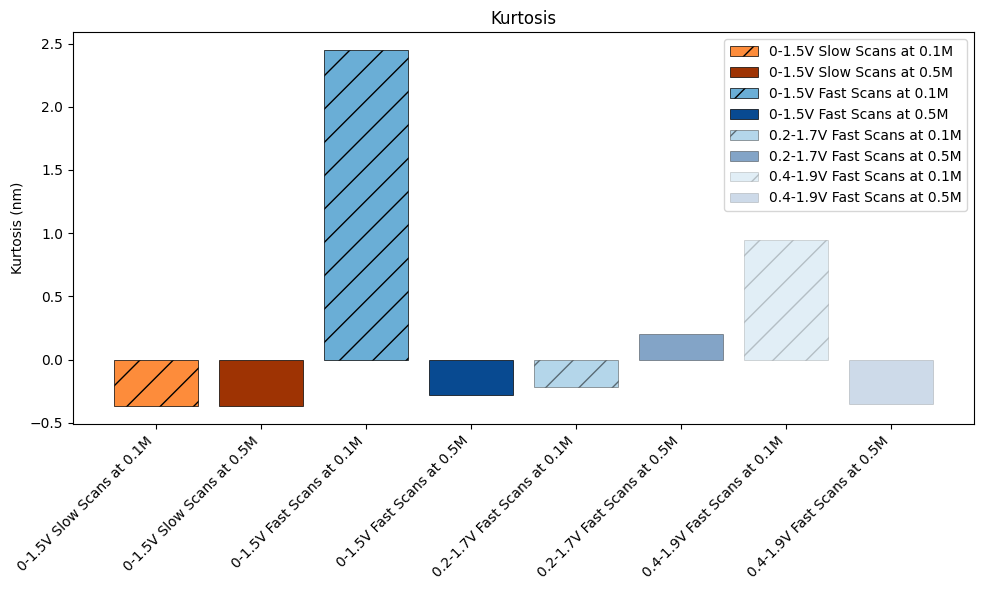

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the table
data = {
    'Sheet Name': [
        '0-1.5V Slow Scans at 0.1M', '0-1.5V Slow Scans at 0.5M', 
        '0-1.5V Fast Scans at 0.1M', '0-1.5V Fast Scans at 0.5M',
        '0.2-1.7V Fast Scans at 0.1M', '0.2-1.7V Fast Scans at 0.5M',
        '0.4-1.9V Fast Scans at 0.1M', '0.4-1.9V Fast Scans at 0.5M'
    ],
    'Ra': [
        985.389560, 985.389560, 1472.069613, 1010.743196, 
        658.445198, 738.857711, 1154.617786, 670.510407
    ],
    'RSm': [
        0.088048, 0.088048, 0.403604, -0.214577, 
        0.226008, 0.307763, -0.259242, 0.615666
    ],
    'Wz': [
        6834.140992, 6834.140992, 12787.905299, 6564.209250, 
        4894.088893, 5744.028609, 11055.588186, 4860.367642
    ],
    'Skewness': [
        -0.197563, -0.197563, 1.143750, -0.546961, 
        -0.280231, -0.344748, 0.119866, -0.124961
    ],
    'Kurtosis': [
        -0.367633, -0.367633, 2.447781, -0.276961, 
        -0.219321, 0.204537, 0.948928, -0.349755
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define colors for different categories and gradients
colors = {
    'Slow Scans 0.1M': plt.cm.Oranges(0.5),
    'Slow Scans 0.5M': plt.cm.Oranges(0.9),
    'Fast Scans 0.1M': plt.cm.Blues(0.5),
    'Fast Scans 0.5M': plt.cm.Blues(0.9)
}

# Define hatch patterns for 0.1M and 0.5M
hatches = {
    '0.1M': '/',
    '0.5M': ''
}

# Plotting parameters
parameters = ['Ra', 'RSm', 'Wz', 'Skewness', 'Kurtosis']
titles = [
    'Arithmetic Average Roughness (Ra)',
    'Slope of the Material Ratio Curve (RSm)',
    'Average Waviness Height (Wz)',
    'Skewness',
    'Kurtosis'
]

# Loop through each parameter to create individual plots
for param, title in zip(parameters, titles):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Loop through each sheet to plot bars
    for j, row in df.iterrows():
        sheet_name = row['Sheet Name']
        
        # Determine the color based on fast/slow scans and starting voltage
        if 'Slow Scans' in sheet_name:
            if '0.1M' in sheet_name:
                color = colors['Slow Scans 0.1M']
            else:
                color = colors['Slow Scans 0.5M']
        else:
            if '0.1M' in sheet_name:
                color = colors['Fast Scans 0.1M']
            else:
                color = colors['Fast Scans 0.5M']
        
        # Adjust alpha channel based on the starting voltage
        if '0.2-' in sheet_name:
            alpha = 0.5  # Lighten the color for 0.2 starting voltage
        elif '0.4-' in sheet_name:
            alpha = 0.2  # Further lighten the color for 0.4 starting voltage
        else:
            alpha = 1.0  # Default alpha
        
        # Plot the bar with appropriate color and hatch pattern
        ax.bar(sheet_name, row[param], label=sheet_name, color=color, hatch=hatches.get('0.1M' if '0.1M' in sheet_name else '0.5M', ''),
               edgecolor='black', linewidth=0.5, alpha=alpha)
    
    ax.set_title(title)
    ax.set_ylabel(f'{param} (nm)')  # Assuming Z values are in nanometers

    # Add a legend
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


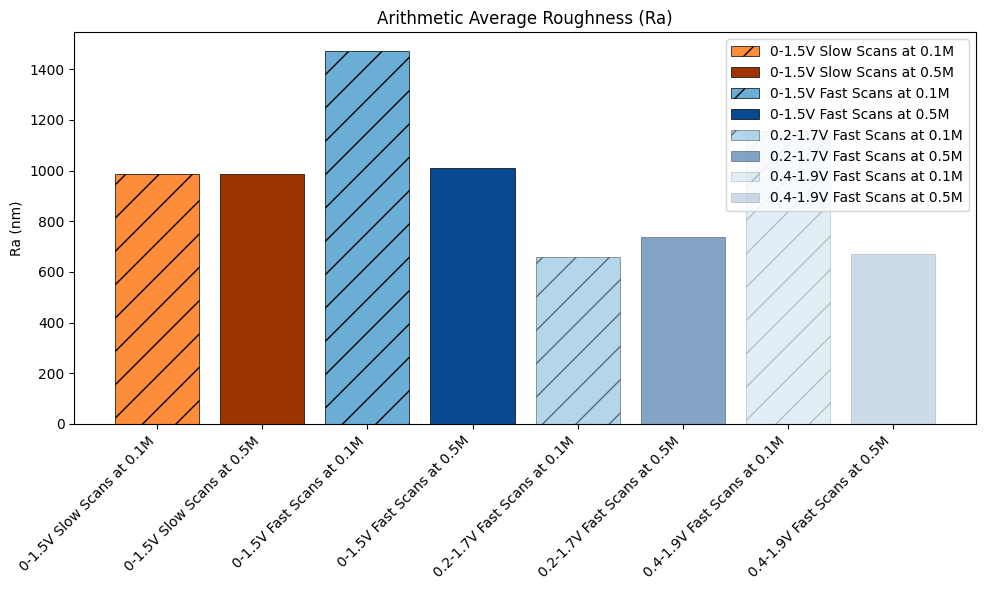

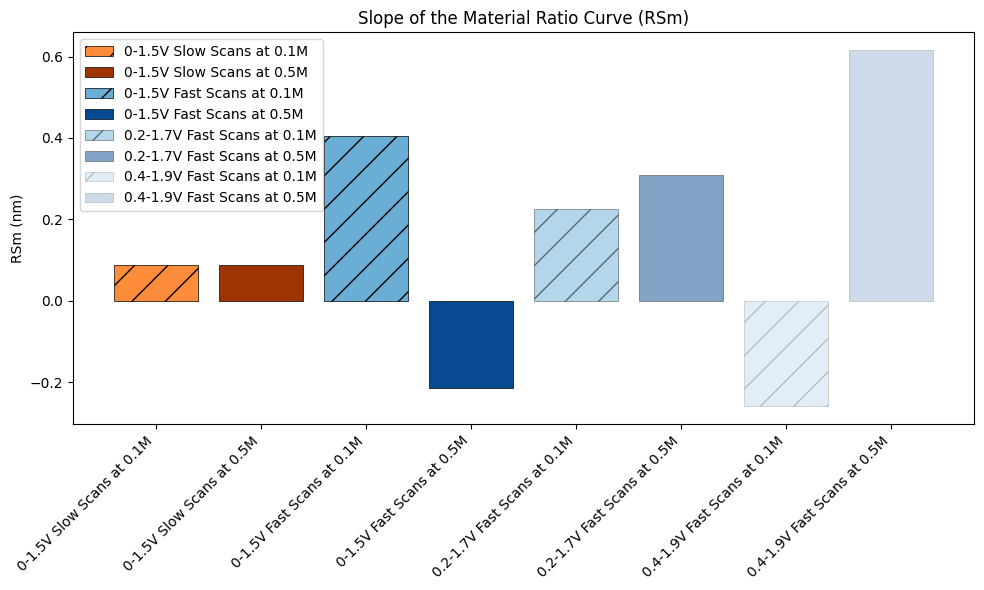

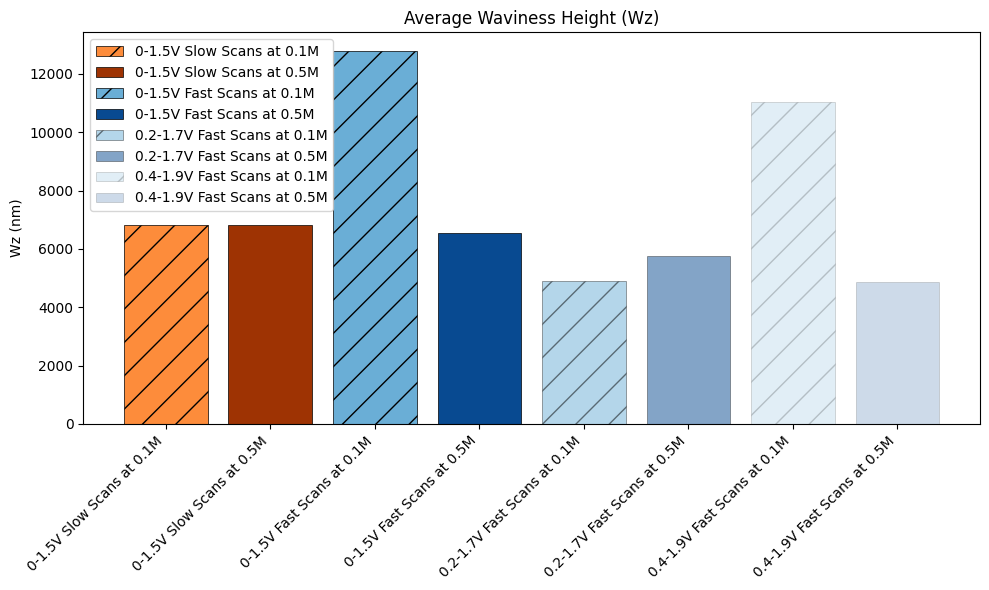

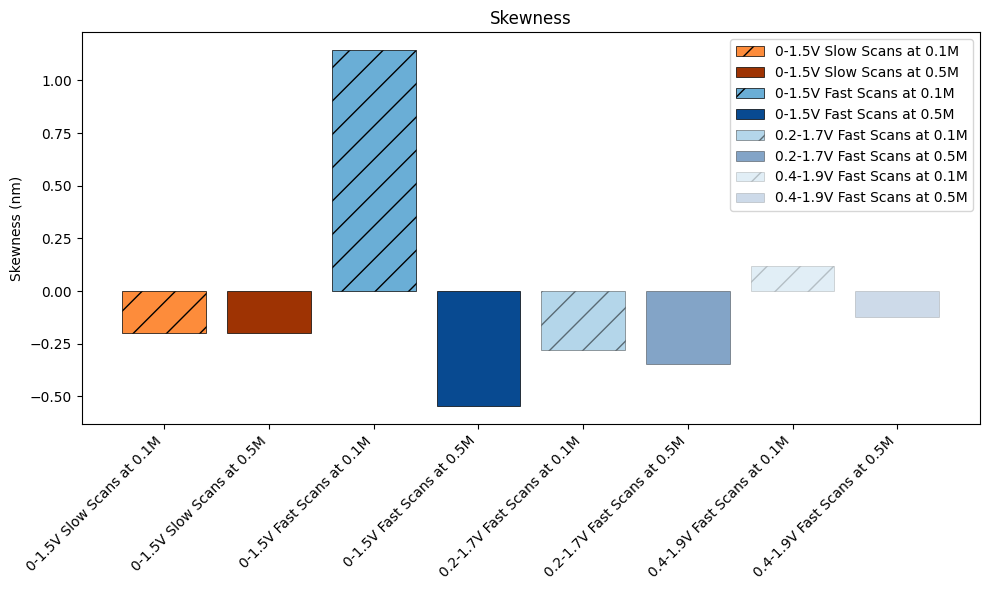

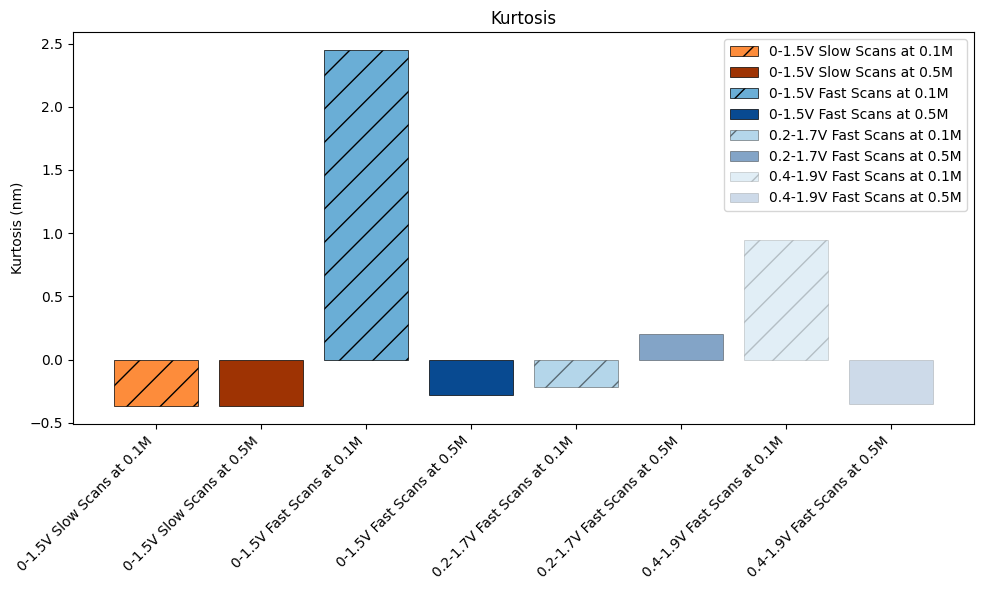

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the table
data = {
    'Sheet Name': [
        '0-1.5V Slow Scans at 0.1M', '0-1.5V Slow Scans at 0.5M', 
        '0-1.5V Fast Scans at 0.1M', '0-1.5V Fast Scans at 0.5M',
        '0.2-1.7V Fast Scans at 0.1M', '0.2-1.7V Fast Scans at 0.5M',
        '0.4-1.9V Fast Scans at 0.1M', '0.4-1.9V Fast Scans at 0.5M'
    ],
    'Ra': [
        985.389560, 985.389560, 1472.069613, 1010.743196, 
        658.445198, 738.857711, 1154.617786, 670.510407
    ],
    'RSm': [
        0.088048, 0.088048, 0.403604, -0.214577, 
        0.226008, 0.307763, -0.259242, 0.615666
    ],
    'Wz': [
        6834.140992, 6834.140992, 12787.905299, 6564.209250, 
        4894.088893, 5744.028609, 11055.588186, 4860.367642
    ],
    'Skewness': [
        -0.197563, -0.197563, 1.143750, -0.546961, 
        -0.280231, -0.344748, 0.119866, -0.124961
    ],
    'Kurtosis': [
        -0.367633, -0.367633, 2.447781, -0.276961, 
        -0.219321, 0.204537, 0.948928, -0.349755
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define colors for different categories and gradients
colors = {
    'Slow Scans 0.1M': plt.cm.Oranges(0.5),
    'Slow Scans 0.5M': plt.cm.Oranges(0.9),
    'Fast Scans 0.1M': plt.cm.Blues(0.5),
    'Fast Scans 0.5M': plt.cm.Blues(0.9)
}

# Define hatch patterns for 0.1M and 0.5M
hatches = {
    '0.1M': '/',
    '0.5M': ''
}

# Plotting parameters
parameters = ['Ra', 'RSm', 'Wz', 'Skewness', 'Kurtosis']
titles = [
    'Arithmetic Average Roughness (Ra)',
    'Slope of the Material Ratio Curve (RSm)',
    'Average Waviness Height (Wz)',
    'Skewness',
    'Kurtosis'
]

# Loop through each parameter to create individual plots
for param, title in zip(parameters, titles):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Loop through each sheet to plot bars
    for j, row in df.iterrows():
        sheet_name = row['Sheet Name']
        
        # Determine the color based on fast/slow scans and starting voltage
        if 'Slow Scans' in sheet_name:
            if '0.1M' in sheet_name:
                color = colors['Slow Scans 0.1M']
            else:
                color = colors['Slow Scans 0.5M']
        else:
            if '0.1M' in sheet_name:
                color = colors['Fast Scans 0.1M']
            else:
                color = colors['Fast Scans 0.5M']
        
        # Adjust alpha channel based on the starting voltage
        if '0.2-' in sheet_name:
            alpha = 0.5  # Lighten the color for 0.2 starting voltage
        elif '0.4-' in sheet_name:
            alpha = 0.2  # Further lighten the color for 0.4 starting voltage
        else:
            alpha = 1.0  # Default alpha
        
        # Plot the bar with appropriate color and hatch pattern
        ax.bar(sheet_name, row[param], label=sheet_name, color=color, hatch=hatches.get('0.1M' if '0.1M' in sheet_name else '0.5M', ''),
               edgecolor='black', linewidth=0.5, alpha=alpha)
    
    ax.set_title(title)
    ax.set_ylabel(f'{param} (nm)')  # Assuming Z values are in nanometers

    # Add a legend
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
